# Capstone Project: Where are you most likely to find a specific kind of venue in Paris ?

Code part

In [1]:
!pip install folium

     |████████████████████████████████| 92kB 16.3MB/s eta 0:00:01


In [2]:
import pandas as pd
import numpy as np
import json
import folium
import requests
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors



## The data
### Get the list of Paris Neighborhoods

We here download the list of neighborhoods of Paris on the data.gouv website as a json file.

In [3]:
!wget -q -O 'paris_data.json' https://www.data.gouv.fr/fr/datasets/r/4765fe48-35fd-4536-b029-4727380ce23c
print('Data downloaded!')

Data downloaded!


In [4]:
with open('paris_data.json') as json_data:
    paris_data = json.load(json_data)

Extract the "features" part of the json file, which is the part where the data is located

In [5]:
#extract the part where the data is
arr_data = paris_data['features']

We now need to transform this data into a DataFrame

In [6]:
# define the dataframe columns
column_names = ['Arrondissement', 'Latitude', 'Longitude'] 

# instantiate the dataframe
arr = pd.DataFrame(columns=column_names)

for data in arr_data:
    arrondissement = data['properties']['l_aroff']
        
    neighborhood_latlon = data['properties']['geom_x_y']
    latitude = neighborhood_latlon[0]
    longitude = neighborhood_latlon[1]
    
    arr = arr.append({'Arrondissement': arrondissement,
                                          'Latitude': latitude,
                                          'Longitude': longitude}, ignore_index=True)

In [7]:
arr

,Arrondissement,Latitude,Longitude
0,Observatoire,48.829245,2.326542
1,Passy,48.860392,2.261971
2,Popincourt,48.859059,2.380058
3,Temple,48.862872,2.360001
4,Reuilly,48.834974,2.421325
5,Louvre,48.862563,2.336443
6,Entrepôt,48.876130,2.360728
7,Vaugirard,48.840085,2.292826
8,Bourse,48.868279,2.342803
9,Hôtel-de-Ville,48.854341,2.357630


In [8]:
print('There are indeed {} arrondissement in Paris'.format(arr.shape[0]))

There are indeed 20 arrondissement in Paris


### Map of Paris and its neighborhoods

We now plot the map of Paris and its arrondissements to have an overview.
We first get the coordinates of Paris and then add the markers

In [9]:
address = 'Paris'

geolocator = Nominatim(user_agent="paris_explorer")
location = geolocator.geocode(address)
paris_latitude = location.latitude
paris_longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris are 48.8634605789, 2.40118812928.


In [10]:
# create map of Paris using latitude and longitude values
map_paris = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=12)

# add markers to map
for lat, lng, arrondissement in zip(arr['Latitude'], arr['Longitude'], arr['Arrondissement']):
    label = '{}'.format(arrondissement)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

### Get venues from Foursquare

Now that we have data about the neighborhoods, we investgate the venues that populate them.  
We first enter my credentials and then define a function that exracts the venues for each neighborhoods

In [11]:
CLIENT_ID = 'KHP2ALXRH4ZO0AFY0Y2T2DIA1A5F1U5KYJOBUWSNPAFFCQU0' # your Foursquare ID
CLIENT_SECRET = 'YV35030ASPVOMQ4PLSID0BIPU2AUC1XUB3RMFCFNOKYSUGD1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KHP2ALXRH4ZO0AFY0Y2T2DIA1A5F1U5KYJOBUWSNPAFFCQU0
CLIENT_SECRET:YV35030ASPVOMQ4PLSID0BIPU2AUC1XUB3RMFCFNOKYSUGD1


In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
LIMIT=1000
paris_venues = getNearbyVenues(names=arr['Arrondissement'],
                                   latitudes=arr['Latitude'],
                                   longitudes=arr['Longitude'])

Observatoire
Passy
Popincourt
Temple
Reuilly
Louvre
Entrepôt
Vaugirard
Bourse
Hôtel-de-Ville
Batignolles-Monceau
Buttes-Montmartre
Élysée
Opéra
Gobelins
Luxembourg
Buttes-Chaumont
Panthéon
Palais-Bourbon
Ménilmontant


Here is an few of the venues that we got.

In [15]:
print(paris_venues.shape)
paris_venues.head()

(2000, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Observatoire,48.829245,2.326542,La Fabrica,48.827711,2.327819,Pizza Place
1,Observatoire,48.829245,2.326542,Les Pipelettes,48.831805,2.326385,Tea Room
2,Observatoire,48.829245,2.326542,Le Petit Baigneur,48.831712,2.324259,French Restaurant
3,Observatoire,48.829245,2.326542,La Maison Courtine,48.833287,2.324629,French Restaurant
4,Observatoire,48.829245,2.326542,Dominique Saibron,48.827965,2.327376,Bakery


## Methodology : Classification

### Prepare the dataset

Here we will use a onehot encoding on the venue types. This will help for the classification. We then split between X (the variables that explain) and y (the variable to be explained).

In [16]:
onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")
onehot['Venue'] = paris_venues['Venue']

df = paris_venues.join(onehot.set_index('Venue'), on='Venue')
df.drop(columns=['Venue Category', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude'], inplace = True)
df.head(2)

,Neighborhood,Venue,African Restaurant,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Auvergne Restaurant,...,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Observatoire,La Fabrica,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Observatoire,Les Pipelettes,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
X = df.drop(columns=['Venue', 'Neighborhood'])
y = df['Neighborhood'].values

In [18]:
#normalize data
from sklearn import preprocessing
#X= preprocessing.StandardScaler().fit(X).transform(X)

In [19]:
# Decision Tree
# We split between training set and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (3134, 211) (3134,)
Test set: (784, 211) (784,)


### Training the Decision Tree

Here we train the algorithm and choose the max depth to use in order to maximise the accuracy

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

MD = 20
acc_DT = np.zeros((MD-1))
for n in range(1,MD):
    
    #Train Model and Predict  
    drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    drugTree.fit(X_train,y_train)    
    predTree = drugTree.predict(X_test)    
    acc_DT[n-1]=metrics.accuracy_score(y_test, predTree)

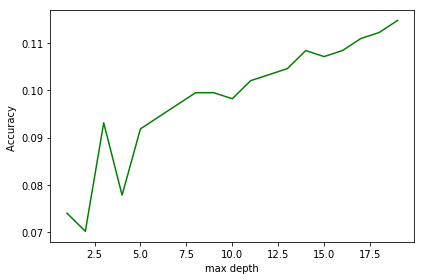

The best accuracy was with 0.11479591836734694 with depth= 19


In [22]:
import matplotlib.pyplot as plt
plt.plot(range(1,MD),acc_DT,'g')
plt.ylabel('Accuracy ')
plt.xlabel('max depth')
plt.tight_layout()
plt.show()
print( "The best accuracy was with", acc_DT.max(), "with depth=", acc_DT.argmax()+1)

In [23]:
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = acc_DT.argmax()+1)
drugTree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=19,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Results

Now that the model is trained, we can now choose the type of venues we want to do the prediction on.  
We first create a function that we will use for the prediction

In [24]:
def to_predict(X_names):
    yhat=[]
    
    #create the X set to predict
    X_pred = df.drop(columns=['Venue', 'Neighborhood']).head(len(X_names)).copy()
    X_pred[X_pred.eq(1)]=0
    for i, name in enumerate(X_names):
        X_pred[name][i] = 1
        
    #do the prediction
    yhat = drugTree.predict(X_pred)
    
    return(yhat)

In [28]:
#set which type of venue you want to search
X_name = ['Greek Restaurant', 'Art Museum']
yhat = to_predict(X_name)
yhat

array(['Temple', 'Louvre'], dtype=object)

### Plot the map

here we plot the map of Paris, adding as markers the venues corresponding to the prediction (only first item of the array of prediction) and the neighborhood predicted.

In [29]:
#map_paris = folium.Map(location=[latitude, longitude], zoom_start=12)

# extract a dataframe of venues corresponding to the data predicted
df = paris_venues[paris_venues['Venue Category'] == X_name[0]]

# add markers to map
for lat, lng, venue in zip(df['Venue Latitude'], df['Venue Longitude'], df['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  

#add marker for the neighborhood predicted
pred = paris_venues[paris_venues['Neighborhood'] == yhat[0]].iloc[0]
lat = pred['Neighborhood Latitude']
lng = pred['Neighborhood Longitude']

folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=folium.Popup('IM HERE : {}'.format(yhat[0]), parse_html=True),
        color='red',
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)

map_paris